In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt


def set_random_seed(seed: int = 123) -> None:
    """
    Seeds everything.

    Args:
        seed (int): Seed to be used.
    """
    random.seed(seed)
    np.random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)


SEED = 123
set_random_seed(SEED)
warnings.filterwarnings("ignore")

## Loading loan data

In [2]:
from utils.dataload import load_loan_data

In [3]:
loan_df = load_loan_data("./data/1.csv")

## IR

In [4]:
import modules.IR as IR

**For rates simulation we will use CIR (Cox–Ingersoll–Ross) model:**

$
d r_{t}=a\left(b-r_{t}\right) d t+\sigma \sqrt{r_{t}} d W_{t}
$

In [5]:
T = 30
r0 = 0.078
kappa = 0.6
sigma = 0.12
r_bar = 0.08
simulations = 3

set_random_seed(SEED)
cir = IR.CIR(T, r0, kappa, sigma, r_bar, simulations)

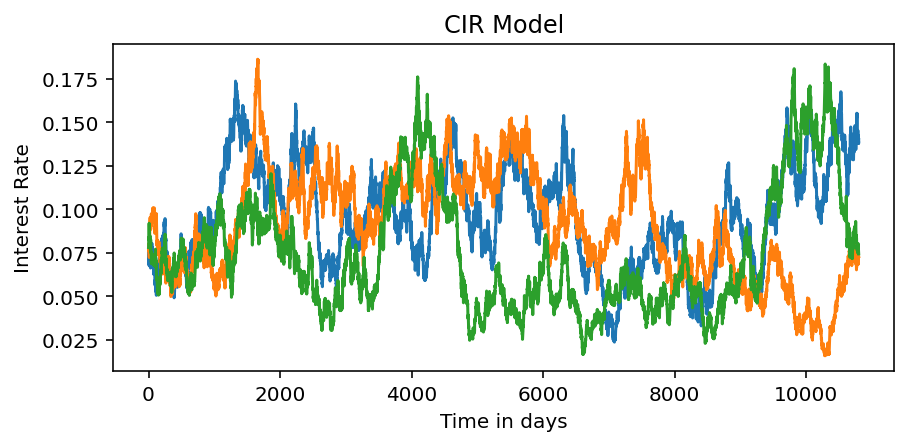

In [6]:
fig = plt.figure(figsize=(7, 3))
plt.plot(cir.T)
plt.xlabel("Time in days")
plt.ylabel("Interest Rate")
plt.title("CIR Model")
plt.show()

## L

In [7]:
import modules.L as L

In [8]:
wac = loan_df["Current_Interest_Rate"].mean()
notional = 100000

In [9]:
CPR = L.generate_CPR(wac, T, notional, r0, kappa, r_bar, sigma, simulations=5)

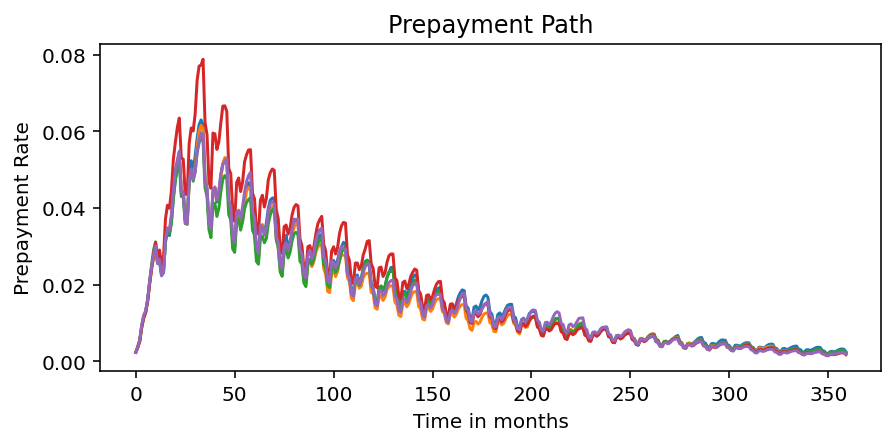

In [10]:
fig = plt.figure(figsize=(7, 3))
plt.plot(CPR.T)
plt.xlabel("Time in months")
plt.ylabel("Prepayment Rate")
plt.title("Prepayment Path")
plt.show()

At the beginning of the mortgage there is a positive spread (i.e. the difference between the value of the portfolio and the cash flow of the mortgage). The difference would compensate the investor if the option is exercised by the borrower. The spread is particularly relevant in the first one hundred months which, in general, corresponds to the time when the prepayment risk is higher. As the prepayment risk becomes less accentuate, the spread decreases.

## CF

In [11]:
import modules.CF as CF

In [12]:
discount_rate = 0.1
portfolio = CF.Loan_Portfolio(discount_rate, loan_df[:2])  # N.B only two loans

Calculating Payments: 100%|██████████| 359/359 [01:20<00:00,  4.45it/s]


In [13]:
flows_aggregate = portfolio.cash_flows_aggregate_for_portfolio()

In [14]:
flow_tranchwise = portfolio.cash_flow_tranchwise(loan_df)

## A

In [15]:
import modules.A as A

In [16]:
price = A.MBS_pricing(portfolio, flows_aggregate, flow_tranchwise)
price.import_MBS_Cashflows()
price.caculate_tranch_value()

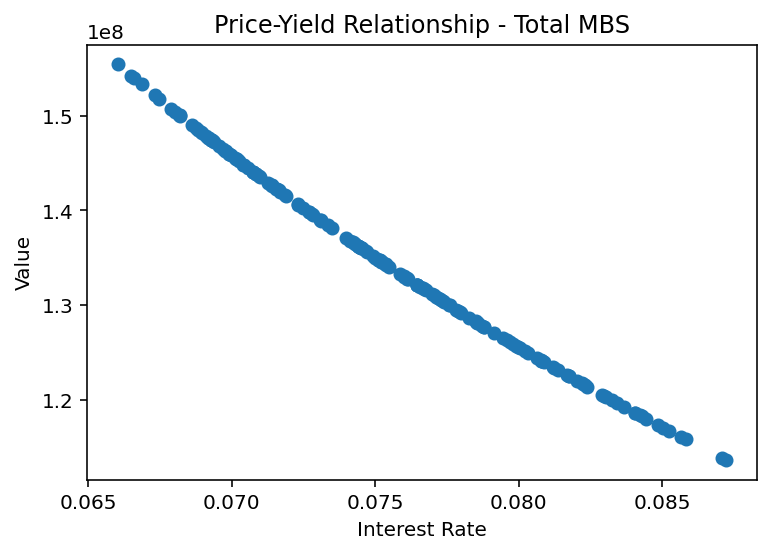

In [17]:
price.plot_mbs_value()